## Demo deserialisation and prediction with a pipeline stored on the file system
The pipeline used in this test is an output of the notebook "BC4_pipeline_training_github.ipynb".
If the previos notebook was run correctly, it should train the best pipeline on the initial dataset and store it on the disk.

Here we will deserialize that pipeline, i.e. load it from the disk into a sklearn object and predict on out-of-sample data, i.e. data that were not seen during the training phase (the January 2016 slice that we left out on purpose).

In [1]:
import pandas as pd
import pandas_bokeh
import json

pandas_bokeh.output_notebook()
#pd.set_option('plotting.backend', 'pandas_bokeh')

Loading BokehJS ...

### 1. Read the harmonized time series in json format

#### - Define directories where the json and rdf files are located
We will get the same data of the training notebook but only select a slice of it for the predictions.

In [2]:
from os import getcwd
from os.path import join

dataset_dir = join(getcwd(), "static_data")
ts_filename = join(dataset_dir, "timeseries.json")
rdf_filename = join(dataset_dir, "timeseries_metadata.ttl")


#### - Visualize fake RDF as a Graph

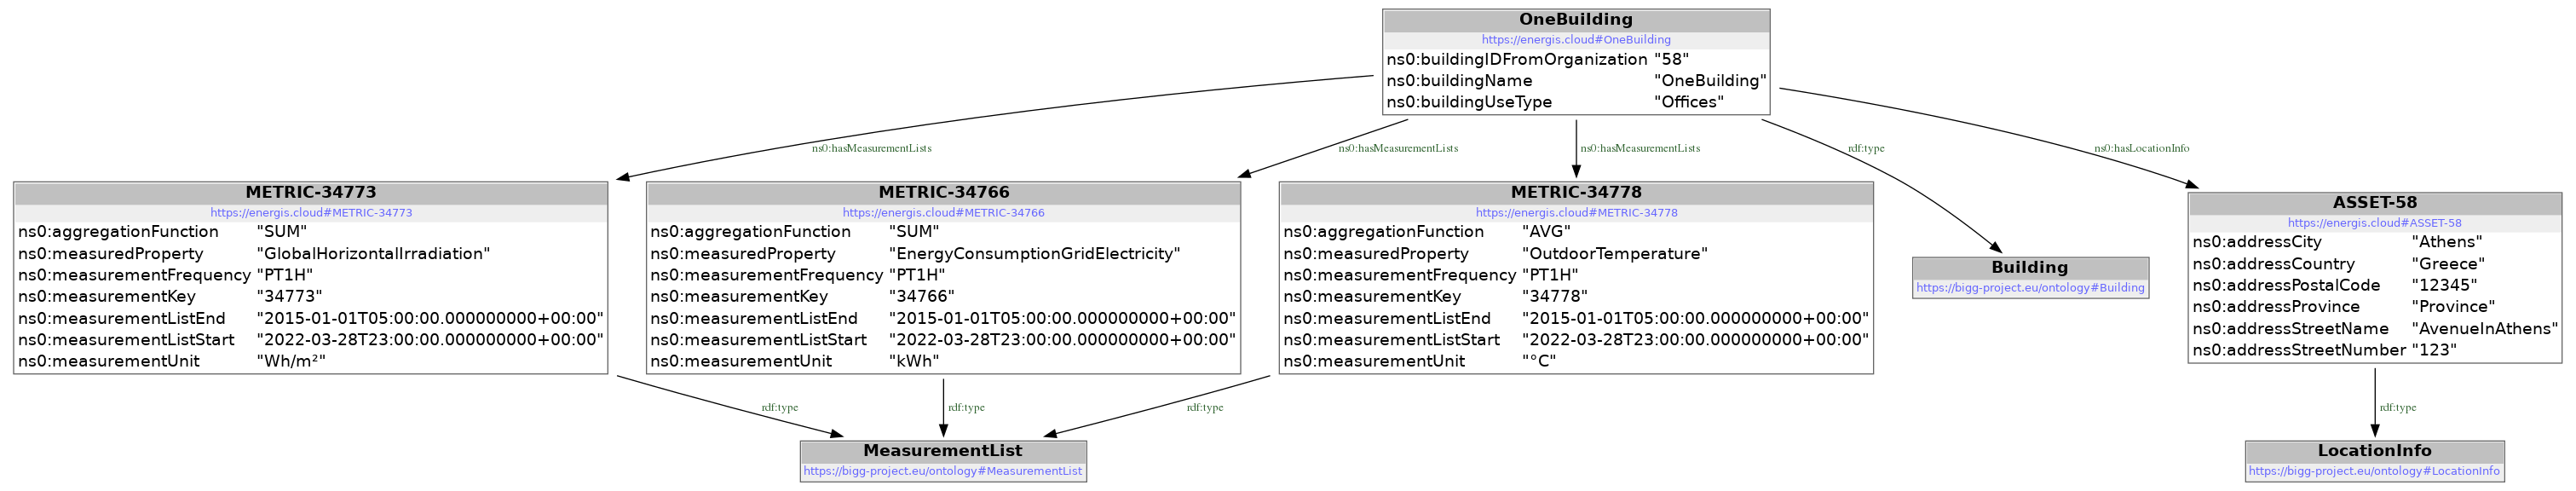

In [3]:
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
from rdflib import Graph, Namespace, URIRef, Literal

def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))
    
g = Graph()
g.parse(rdf_filename, format="ttl")
visualize(g)

#### - De-harmonise the data
We get only the out-of-sample slice as new X data (January 2016)

In [4]:
def get_aggregation(function: str) -> str:
        if function.lower() in ['avg', 'average']:
            return 'mean'
        else: 
            return function.lower()

def harmonized_dict_to_dataframe(data: dict, graph: Graph, ontology: str='https://bigg-project.eu/ontology#') -> (pd.DataFrame, dict):
    
    df_list = []
    agg_functions = {}
    namespace_ontology = Namespace(ontology)
    
    for name, time_series in data.items():
        measurement_list = graph.value(None, namespace_ontology['measurementKey'], Literal(name))
        if measurement_list is not None:
            measured_property = str(graph.value(measurement_list, namespace_ontology['measuredProperty'], None))
            agg_function = str(graph.value(measurement_list, namespace_ontology['aggregationFunction'], None))
            agg_functions[measured_property] = get_aggregation(agg_function)
        else:
            measured_property = name
        df_temp = pd.DataFrame.from_records(
                        time_series,
                        columns=["measurementStart", "value"]).rename(columns={"measurementStart": "timestamp", "value": measured_property})
        df_temp["timestamp"] = pd.to_datetime(
                    df_temp["timestamp"],
                    infer_datetime_format=True)
        df_temp.set_index('timestamp', inplace=True)
        df_list.append(df_temp)
        
    return pd.concat(df_list, axis=1), agg_functions


with open(ts_filename, 'r') as f:
    df, aggregations = harmonized_dict_to_dataframe(data=json.load(f), graph=g)
    
    
# Out-of-sample slice (January 2016)
target = "EnergyConsumptionGridElectricity"
df = df.loc["2016"]
df

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation
timestamp,,,
2016-01-01 00:00:00+00:00,94.86,4.99,0.0
2016-01-01 01:00:00+00:00,96.00,2.65,0.0
2016-01-01 02:00:00+00:00,99.24,2.64,0.0
2016-01-01 03:00:00+00:00,99.06,2.12,0.0
2016-01-01 04:00:00+00:00,89.40,2.57,0.0
...,...,...,...
2016-01-31 19:00:00+00:00,96.06,11.46,0.0
2016-01-31 20:00:00+00:00,89.16,11.08,0.0
2016-01-31 21:00:00+00:00,86.58,10.68,0.0


### - Deserialise the pipeline and predict

#### - Define X data
We will take only the out-of-sample slice for the predictions as new X data

In [5]:
predictors = [feature for feature in list(df.columns) if feature not in [target]]
new_X_data = df.loc[:, predictors]
new_X_data

,OutdoorTemperature,GlobalHorizontalIrradiation
timestamp,,
2016-01-01 00:00:00+00:00,4.99,0.0
2016-01-01 01:00:00+00:00,2.65,0.0
2016-01-01 02:00:00+00:00,2.64,0.0
2016-01-01 03:00:00+00:00,2.12,0.0
2016-01-01 04:00:00+00:00,2.57,0.0
...,...,...
2016-01-31 19:00:00+00:00,11.46,0.0
2016-01-31 20:00:00+00:00,11.08,0.0
2016-01-31 21:00:00+00:00,10.68,0.0


#### - Deserialise the pipeline and predict on the new X data
After, we will also add the prediction column to the initial data, where we have also the ground truth, only for visualization purposes.

In [6]:
from ai_toolbox.data_modelling import deserialize_and_predict

model_filename = "best_pipeline_bc4"
extension = ".cloudpickle"
model_full_path = join(dataset_dir, "{}{}".format(model_filename, extension))
df["y_pred"] = deserialize_and_predict(model_full_path, new_X_data)
df

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation,y_pred
timestamp,,,,
2016-01-01 00:00:00+00:00,94.86,4.99,0.0,97.57830
2016-01-01 01:00:00+00:00,96.00,2.65,0.0,100.21640
2016-01-01 02:00:00+00:00,99.24,2.64,0.0,101.16732
2016-01-01 03:00:00+00:00,99.06,2.12,0.0,100.00800
2016-01-01 04:00:00+00:00,89.40,2.57,0.0,99.24180
...,...,...,...,...
2016-01-31 19:00:00+00:00,96.06,11.46,0.0,83.96850
2016-01-31 20:00:00+00:00,89.16,11.08,0.0,90.51180
2016-01-31 21:00:00+00:00,86.58,10.68,0.0,88.71300


#### - Plot Actual Consumption and predictions
We want to visualize how the predictions will look like

In [7]:
df.plot_bokeh.line(
    title = "Predictions vs Actual Consumptions",
    x=df.index, 
    y=["EnergyConsumptionGridElectricity", "y_pred"],
    figsize=(1200, 600),
    ylim=(0, 1000),
    zooming=True,
    panning=True,
    rangetool=True
)

Column(id='1136', ...)